### K-Medoids

#### MNIST

In [1]:
from sklearn_extra.cluster import KMedoids

import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
import alibi
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from time import time
from alibi.explainers import CounterFactualProto
print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False

TF version:  2.4.1
Eager execution enabled:  False


In [2]:
from sklearn_extra.cluster import KMedoids

x_train shape: (60000, 28, 28) y_train shape: (60000,)


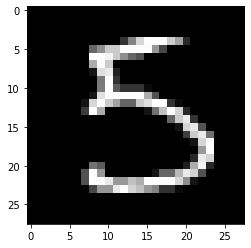

In [3]:
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)
plt.gray()
plt.imshow(x_test[15]);

In [4]:
# loading etc

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)
y_train shape: (60000, 10) y_test shape: (10000, 10)


In [5]:
#normalizing
xmin, xmax = -.5, .5
x_train = ((x_train - x_train.min()) / (x_train.max() - x_train.min())) * (xmax - xmin) + xmin
x_test = ((x_test - x_test.min()) / (x_test.max() - x_test.min())) * (xmax - xmin) + xmin

In [6]:
def km_prototyper():
    prototypes = []
    for digit in range(0,10):
        
        x_train_subset = [x_train[i] for i in np.where(np.argmax(y_train, axis=1)==digit)[0]]
        x_train_subset = np.array(x_train_subset)
        
        kmedoids = KMedoids(n_clusters=10, random_state=0).fit(x_train_subset.reshape(x_train_subset.shape[0],784))
        prototypes.append(kmedoids.cluster_centers_)
    
    return prototypes

In [7]:
x_train_subset = [x_train[i] for i in np.where(np.argmax(y_train, axis=1)==4)[0]]
x_train_subset = np.array(x_train_subset)

In [8]:
x_train_subset.shape[0]

5842

In [9]:
prototype_data = []

for class_item in range(10):
    
    x_train_subset = [x_train[i] for i in np.where(np.argmax(y_train, axis=1)==class_item)[0]]
    x_train_subset = np.array(x_train_subset)
    
    kmedoids = KMedoids(n_clusters=10, random_state=0).fit(x_train_subset.reshape(x_train_subset.shape[0],784))
    
    prototype_data.append(kmedoids.cluster_centers_.reshape(10,28,28,1))
    
    
    

In [10]:
prototype_data = np.array(prototype_data)

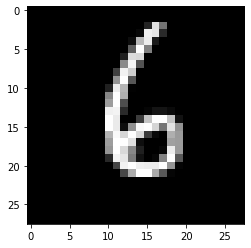

In [11]:
plt.imshow(prototype_data[6][2])

In [12]:
np.save('prototypes_mnist_kmedoids.npy', prototype_data)

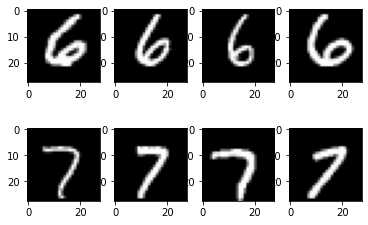

In [13]:
f, axarr = plt.subplots(nrows=2,ncols=4)
plt.sca(axarr[0,0]); 
plt.imshow(prototype_data[6][0]); plt.title('')
plt.sca(axarr[0,1]); 
plt.imshow(prototype_data[6][1]); plt.title('')
plt.sca(axarr[0,2]); 
plt.imshow(prototype_data[6][2]); plt.title(''); 
plt.sca(axarr[0,3]); 
plt.imshow(prototype_data[6][3]); plt.title(''); 


plt.sca(axarr[1,0]); 
plt.imshow(prototype_data[7][9]); plt.title('')
plt.sca(axarr[1,1]); 
plt.imshow(prototype_data[7][8]); plt.title('')
plt.sca(axarr[1,2]); 
plt.imshow(prototype_data[7][6]); plt.title(''); 
plt.sca(axarr[1,3]); 
plt.imshow(prototype_data[7][7]); plt.title(''); 



plt.show()

In [14]:
G1 = np.load('user_explanations_g1.npy')
G2 = np.load('user_explanations_g2.npy')

In [15]:
G1[0].shape

(50, 28, 28, 1)

In [16]:
user_explanation_centroids = []


for image in range(50):


    data_example = []

    for user in range(21):

        data_example.append(G1[user][image])


    data_example = np.array(data_example)

    kmedoids = KMedoids(n_clusters=1, random_state=0).fit(data_example.reshape(21,784))

    user_explanation_centroids.append(kmedoids.cluster_centers_.reshape(1,28,28,1))
    
user_explanation_centroids = np.array(user_explanation_centroids).reshape(50,28,28,1)

In [17]:
user_explanation_centroids = np.array(user_explanation_centroids).reshape(50,28,28,1)

In [18]:
np.save('G1_centroids.npy', user_explanation_centroids)

In [19]:
user_explanation_centroids = []


for image in range(50):


    data_example = []

    for user in range(21):

        data_example.append(G2[user][image])


    data_example = np.array(data_example)

    kmedoids = KMedoids(n_clusters=1, random_state=0).fit(data_example.reshape(21,784))

    user_explanation_centroids.append(kmedoids.cluster_centers_.reshape(1,28,28,1))
    
user_explanation_centroids = np.array(user_explanation_centroids).reshape(50,28,28,1)

In [20]:
np.save('G2_centroids.npy', user_explanation_centroids)

#### Quickdraw

In [21]:
user_explanations_quickdraw = np.load('user_explanations_quickdraw.npy')

In [22]:
user_explanation_centroids_quickdraw = []


for image in range(30):


    data_example_quickdraw = []

    for user in range(5):

        data_example_quickdraw.append(user_explanations_quickdraw[user][image])


    data_example_quickdraw = np.array(data_example_quickdraw)

    kmedoids_quickdraw = KMedoids(n_clusters=1, random_state=0).fit(data_example_quickdraw.reshape(5,784))

    user_explanation_centroids_quickdraw.append(kmedoids_quickdraw.cluster_centers_.reshape(1,28,28,1))
    
user_explanation_centroids_quickdraw = np.array(user_explanation_centroids_quickdraw).reshape(30,28,28,1)

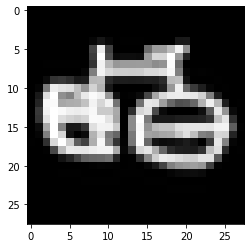

In [37]:
plt.imshow(user_explanation_centroids_quickdraw[12])

In [38]:
np.save('user_kmed_prototypes_quickdraw.npy', user_explanation_centroids_quickdraw)

In [40]:
x_train = np.load('quickdraw_x_train.npy')
y_train = np.load('quickdraw_y_train.npy')

In [42]:
prototype_data = []

for class_item in range(5):
    
    x_train_subset = [x_train[i] for i in np.where(np.argmax(y_train, axis=1)==class_item)[0]]
    x_train_subset = np.array(x_train_subset)
    
    kmedoids = KMedoids(n_clusters=10, random_state=0).fit(x_train_subset.reshape(x_train_subset.shape[0],784))
    
    prototype_data.append(kmedoids.cluster_centers_.reshape(10,28,28,1))

In [43]:
prototype_data = np.array(prototype_data)

In [45]:
prototype_data.shape

(5, 10, 28, 28, 1)

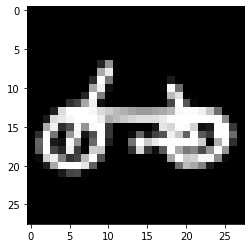

In [59]:
plt.imshow(prototype_data[2][9])